## Cargar los modelos

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, accuracy_score
from keras.utils import np_utils
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_files 
from keras.preprocessing import image
import seaborn as sns

In [14]:
inceptionResNet_model = tf.keras.models.load_model('modelos/02_efficientNet_model_final')

# Evaluación de los modelos

In [15]:
test_dir = "/Users/inma/Desktop/tfg/datos/test"
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
test_data = test_gen.flow_from_directory(test_dir,
                                           target_size = (224,224),
                                           class_mode = "categorical",
                                           batch_size = 64
                                          )

Found 1072 images belonging to 3 classes.


In [16]:
inceptionResNet_model_evaluation = inceptionResNet_model.evaluate(test_data)

17/17 [==============================] - 92s 5s/step - loss: 1.0945 - accuracy: 0.3545


### Comparación - Métricas de evaluación

#### 1. Accuracy

In [17]:
print(f"InceptionResNet Model Accuarcy : {inceptionResNet_model_evaluation[1] *100 : 0.2f}%")

InceptionResNet Model Accuarcy :  35.45%


Los resultados son mejores.

#### 2. Test Loss

In [18]:
print(f"InceptionResNet Model TestLoss : {inceptionResNet_model_evaluation[0] *100 : 0.2f}%")

InceptionResNet Model TestLoss :  109.45%


#### 3. ROC AUC

In [19]:
num_test = len(test_data.filenames)/64

labels = np_utils.to_categorical(np.array(test_data.classes), 3)

In [20]:
labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [21]:
predictions_inception = inceptionResNet_model.predict(test_data)

##### Calcular auc:

In [22]:
roc_auc_all_inception = roc_auc_score(labels, predictions_inception)
print(f'InceptionResNet Model AUC: {roc_auc_all_inception *100 : 0.2f}%')

InceptionResNet Model AUC:  50.43%


## Visualizar resultados

In [23]:
def load_data_raw (path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 3)
    
    return files, targets

test_filenames, test_targets = load_data_raw(test_dir)

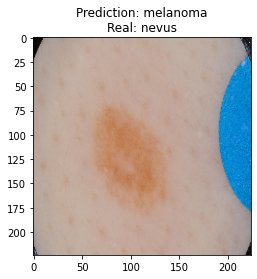

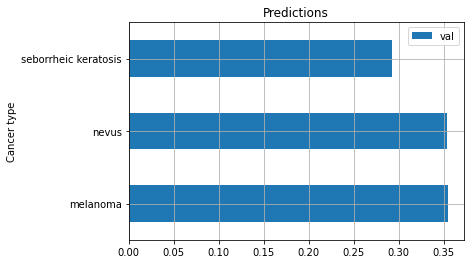

In [24]:
class_2_indices = {'melanoma': 0, 'nevus': 1, 'seborrheic_keratoses': 2}
indices_2_class = {v: k for k, v in class_2_indices.items()}

def plot_prediction(img_file, img_target, model):

    img = image.load_img(img_file, target_size=(224,224))
    img = image.img_to_array(img)/255
    img_expand = np.expand_dims(img, axis=0)
    
    # Make a prediction
    prediction = model.predict(img_expand, steps=1)
    image_idx = np.argmax(prediction[0])
    prediction_string = indices_2_class[image_idx]
    
    # Get the real label's name
    label_idx = np.argmax(img_target)
    real_label = indices_2_class[label_idx]
    
    # Plot predictions
    title = "Prediction: {}\nReal: {}".format(prediction_string, real_label)
    
    plt.imshow(img)
    plt.title(title)
    
    pred_df = pd.DataFrame({'Cancer type':['melanoma', 'nevus', 'seborrheic keratosis'], 'val':prediction[0]})
    ax = pred_df.plot.barh(x='Cancer type', y='val', title="Predictions", grid=True)
    
random_index = np.random.randint(0, len(test_data.filenames))
plot_prediction(test_filenames[random_index], test_targets[random_index], inceptionResNet_model)

#### Matriz de confusión

[Text(0, 0.5, 'melanoma'), Text(0, 1.5, 'nevus'), Text(0, 2.5, 'keratoses')]

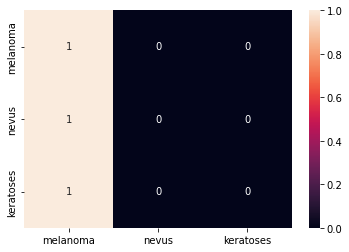

In [25]:
# Confusion matrix for all classes
y_true = test_data.classes
y_pred = [np.argmax(x) for x in predictions_inception]

labels = ["melanoma", "nevus", "keratoses"]
cm = confusion_matrix(y_true, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Normalize confusion matrix
ax = sns.heatmap(cm, annot=True)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)